In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:

# --- 1. DATA PREPARATION ---

# For demonstration, we'll create a sample DataFrame.
# Replace this part with your actual data loading:
df = pd.read_csv('augmented_hanoi_weather_data_FINAL.csv')
# data = {
#     'DateTime': pd.to_datetime(pd.date_range(start='2024-01-01', periods=8728, freq='H')),
#     'weather main': np.random.choice(['Clear', 'Clouds', 'Rain', 'Drizzle'], 8728),
#     'weather description': np.random.choice(['clear sky', 'few clouds', 'light rain', 'scattered clouds', 'moderate rain'], 8728),
#     'Temperature (C)': np.random.uniform(15, 35, 8728),
#     'feels like': np.random.uniform(15, 38, 8728),
#     'Pressure (hPa)': np.random.randint(1000, 1020, 8728),
#     'sea level pressure': np.nan,
#     'grnd level pressure': np.nan,
#     'Humidity %': np.random.randint(40, 95, 8728),
#     'wind speed (m/s)': np.random.uniform(1, 10, 8728),
#     'wind deg': np.random.randint(0, 360, 8728),
#     'wind gust': np.random.uniform(2, 15, 8728),
#     'cloudiness (%)': np.random.randint(0, 100, 8728),
#     'rain volumn (mm/h)': [np.random.choice([0, 0.5, 1.2, 0]) for _ in range(8728)],
#     'snow volumn (mm/h)': np.nan,
#     'icon id': 'some_id'
# }
# df = pd.DataFrame(data)
df['rain volumn (mm)'] = df['rain volumn (mm)'].replace(0, np.nan)


# Clean column names
df.columns = [
    'datetime', 'weather_main', 'weather_desc', 'temp_c', 'feels_like_c',
    'pressure_hpa', 'humidity_pct',
    'wind_speed_ms', 'wind_deg', 'wind_gust_ms', 'cloudiness_pct',
    'rain_mmh', 'icon_id'
]

# Drop unnecessary columns (keeping 'weather_desc' as discussed)
df = df.drop(columns=[
        'icon_id', 'weather_desc'
])

# Process data
df['rain_mmh'] = df['rain_mmh'].fillna(0)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Feature Engineering
df['pop'] = (df['rain_mmh'] > 0).astype(int)
df['wind_deg_sin'] = np.sin(np.radians(df['wind_deg']))
df['wind_deg_cos'] = np.cos(np.radians(df['wind_deg']))
df = df.drop(columns=['wind_deg'])
df = pd.get_dummies(df, columns=['weather_main'], prefix='desc')
df.head()


,temp_c,feels_like_c,pressure_hpa,humidity_pct,wind_speed_ms,wind_gust_ms,cloudiness_pct,rain_mmh,pop,wind_deg_sin,wind_deg_cos,desc_Clear,desc_Clouds,desc_Rain
datetime,,,,,,,,,,,,,,
2024-04-25 00:00:00,23.96,24.60,1005.0,80.0,1.85,3.67,26.0,0.00,0,0.292372,-0.956305,False,True,False
2024-04-25 01:00:00,23.96,24.78,1005.0,87.0,0.54,2.30,45.0,0.00,0,-0.927184,-0.374607,False,True,False
2024-04-25 02:00:00,24.96,24.96,1004.0,88.0,0.97,1.36,7.0,3.55,1,0.999848,-0.017452,False,False,True
2024-04-25 03:00:00,24.96,24.96,1004.0,88.0,0.99,1.43,10.0,0.56,1,0.978148,-0.207912,False,False,True
2024-04-25 04:00:00,23.96,24.81,1004.0,88.0,1.08,1.51,13.0,0.00,0,0.965926,-0.258819,False,True,False


# Build the Hourly Forecast Model (Next 5 Hours)


--- Hourly Model Shapes ---
X_train shape: (13944, 24, 14)
y_train shape: (13944, 15)
X_val shape: (3465, 24, 14)
y_val shape: (3465, 15)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 100)           46000     
                                                                 
 dropout (Dropout)           (None, 24, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 15)                765       
                                                                 
Total params: 76,965
Trainable params: 76,965
Non-

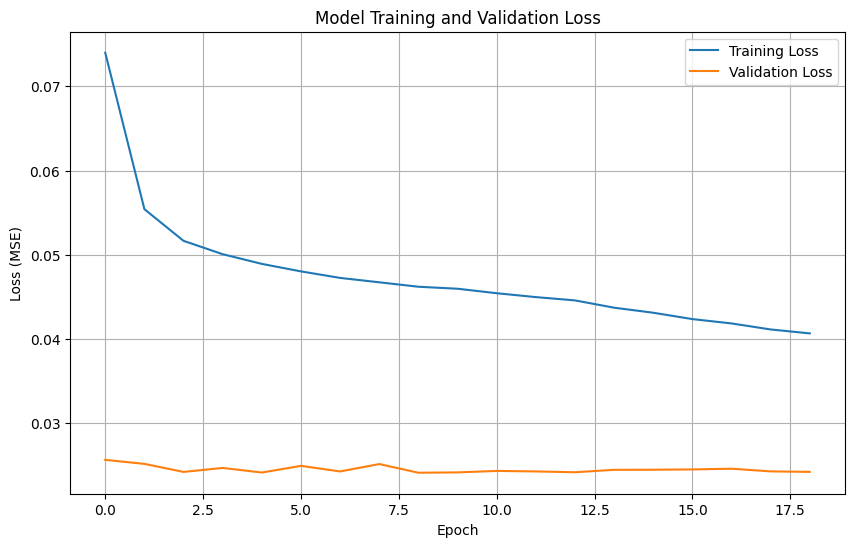

109/109 [==============================] - 4s 32ms/step


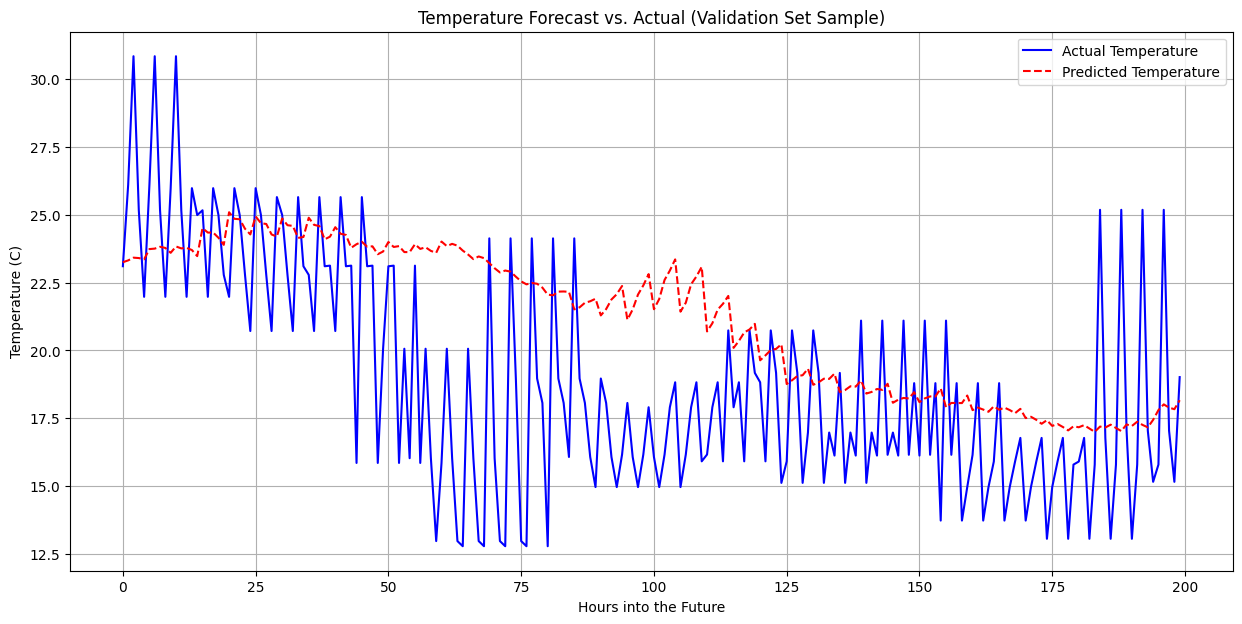


--- Model Performance on Validation Set ---
Mean Absolute Error (Temperature): 2.91 °C
Mean Absolute Error (PoP): 0.06
Mean Absolute Error (Humidity): 13.93 %
1/1 [==============================] - 0s 28ms/step

--- Final 5-Hour Forecast ---
                        temp_c       pop  humidity_pct
2026-04-24 01:00:00  26.868690  0.181172     77.095886
2026-04-24 02:00:00  26.587593  0.157623     78.138214
2026-04-24 03:00:00  26.575563  0.169816     79.875191
2026-04-24 04:00:00  26.006454  0.172645     79.988945
2026-04-24 05:00:00  26.162912  0.167190     81.223602


C:\Users\minht\AppData\Local\Temp\ipykernel_50796\2175267284.py:126: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=N_FUTURE, freq='H')


In [4]:

# Define targets and reorder columns
targets_hourly = ['temp_c', 'pop', 'humidity_pct']
feature_cols = [col for col in df.columns if col not in targets_hourly]
df_ordered = df[targets_hourly + feature_cols]

# Scale data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_ordered)
scaler_targets = MinMaxScaler()
scaler_targets.fit(df_ordered[targets_hourly])


# --- 2. CREATE SEQUENCES FOR LSTM ---

def create_sequences(data, n_past, n_future, target_indices):
    X, y = [], []
    for i in range(len(data) - n_past - n_future + 1):
        X.append(data[i : i + n_past])
        y.append(data[i + n_past : i + n_past + n_future, target_indices])
    return np.array(X), np.array(y)

# Model parameters
N_PAST = 24       # Use the past 24 hours
N_FUTURE = 5      # To predict the next 5 hours
N_TARGETS = len(targets_hourly)
target_indices = [0, 1, 2]

# Split data into training (80%) and validation (20%)
split_index = int(len(df_scaled) * 0.8)
train_data = df_scaled[:split_index]
val_data = df_scaled[split_index:]

# Create sequences
X_train, y_train = create_sequences(train_data, N_PAST, N_FUTURE, target_indices)
X_val, y_val = create_sequences(val_data, N_PAST, N_FUTURE, target_indices)

# Reshape y for the model's output layer
y_train = y_train.reshape(y_train.shape[0], N_FUTURE * N_TARGETS)
y_val = y_val.reshape(y_val.shape[0], N_FUTURE * N_TARGETS)

print("--- Hourly Model Shapes ---")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# --- 3. BUILD AND TRAIN THE LSTM MODEL ---

hourly_model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(N_FUTURE * N_TARGETS)
])

hourly_model.compile(optimizer='adam', loss='mse')
hourly_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = hourly_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# --- 4. EVALUATE THE MODEL ---

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions on the validation set
val_predictions_scaled = hourly_model.predict(X_val)

# Inverse transform predictions and actuals to their original scale
val_predictions_actual = scaler_targets.inverse_transform(val_predictions_scaled.reshape(-1, N_TARGETS))
y_val_actual = scaler_targets.inverse_transform(y_val.reshape(-1, N_TARGETS))

# Plot a sample of predictions vs actuals
plt.figure(figsize=(15, 7))
plt.plot(y_val_actual[:200, 0], label='Actual Temperature', color='blue')
plt.plot(val_predictions_actual[:200, 0], label='Predicted Temperature', color='red', linestyle='--')
plt.title('Temperature Forecast vs. Actual (Validation Set Sample)')
plt.xlabel('Hours into the Future')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print Mean Absolute Error
mae_temp = mean_absolute_error(y_val_actual[:, 0], val_predictions_actual[:, 0])
mae_pop = mean_absolute_error(y_val_actual[:, 1], val_predictions_actual[:, 1])
mae_humidity = mean_absolute_error(y_val_actual[:, 2], val_predictions_actual[:, 2])

print("\n--- Model Performance on Validation Set ---")
print(f"Mean Absolute Error (Temperature): {mae_temp:.2f} °C")
print(f"Mean Absolute Error (PoP): {mae_pop:.2f}")
print(f"Mean Absolute Error (Humidity): {mae_humidity:.2f} %")


# --- 5. MAKE A FINAL FORECAST ---

# Use the last N_PAST hours from the original dataset to predict the next N_FUTURE hours
last_sequence = df_scaled[-N_PAST:]
X_pred = np.expand_dims(last_sequence, axis=0)
final_prediction_scaled = hourly_model.predict(X_pred)
final_prediction_reshaped = final_prediction_scaled.reshape(N_FUTURE, N_TARGETS)
final_prediction_actual = scaler_targets.inverse_transform(final_prediction_reshaped)

print("\n--- Final 5-Hour Forecast ---")
forecast_df = pd.DataFrame(
    final_prediction_actual,
    columns=targets_hourly,
    index=pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=N_FUTURE, freq='H')
)
print(forecast_df)

--- Hourly Model Shapes ---
X_train shape: (6954, 24, 14)
y_train shape: (6954, 15)
X_val shape: (1718, 24, 14)
y_val shape: (1718, 15)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 100)           46000     
                                                                 
 dropout_4 (Dropout)         (None, 24, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 15)                765       
                                                                 
Total params: 76,965
Trainable params: 76,965
Non-

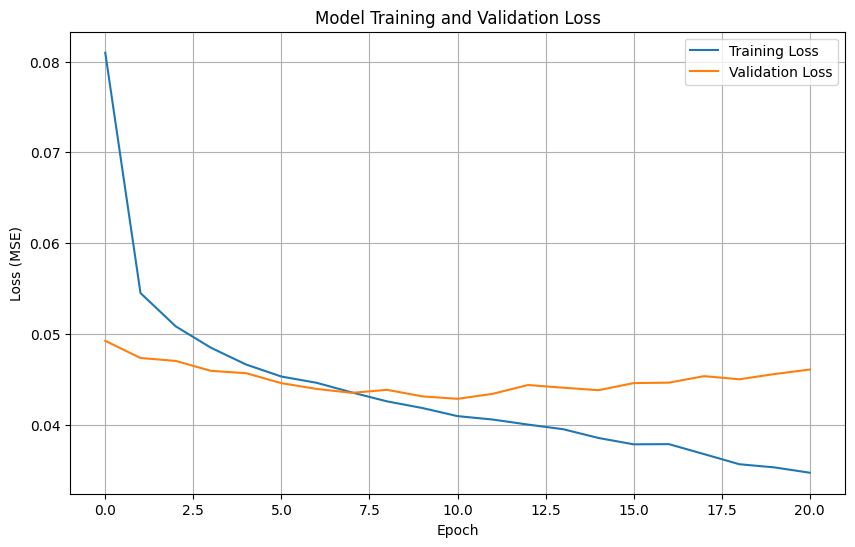

54/54 [==============================] - 2s 32ms/step


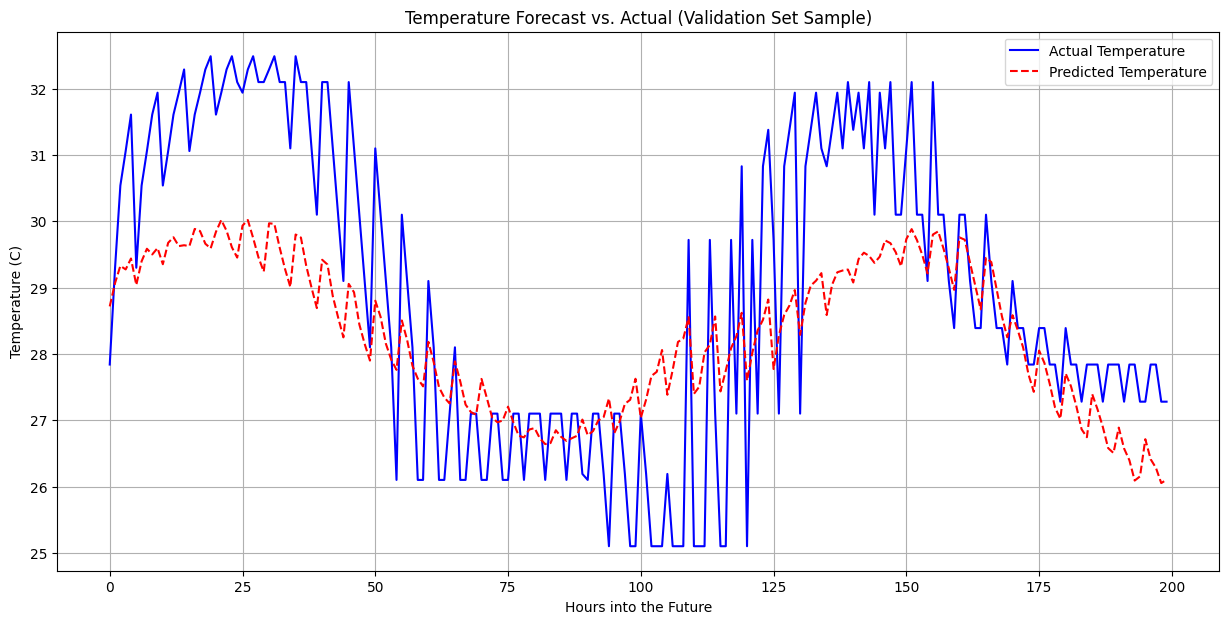


--- Model Performance on Validation Set ---
Mean Absolute Error (Temperature): 1.07 °C
Mean Absolute Error (PoP): 0.22
Mean Absolute Error (Humidity): 6.96 %
1/1 [==============================] - 0s 29ms/step

--- Final 5-Hour Forecast ---
                        temp_c       pop  humidity_pct
2025-04-24 01:00:00  26.574080  0.070588     96.092667
2025-04-24 02:00:00  26.645761  0.073501     95.626854
2025-04-24 03:00:00  26.584320  0.069813     96.098000
2025-04-24 04:00:00  26.636547  0.064245     94.889084
2025-04-24 05:00:00  26.886486  0.066599     94.796349


C:\Users\minht\AppData\Local\Temp\ipykernel_50796\1301046874.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=N_FUTURE, freq='H')


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. DATA PREPARATION ---

# For demonstration, we'll create a sample DataFrame.
# Replace this part with your actual data loading:
df = pd.read_csv('Halong_Weather_Data.csv')
# data = {
#     'DateTime': pd.to_datetime(pd.date_range(start='2024-01-01', periods=8728, freq='H')),
#     'weather main': np.random.choice(['Clear', 'Clouds', 'Rain', 'Drizzle'], 8728),
#     'weather description': np.random.choice(['clear sky', 'few clouds', 'light rain', 'scattered clouds', 'moderate rain'], 8728),
#     'Temperature (C)': np.random.uniform(15, 35, 8728),
#     'feels like': np.random.uniform(15, 38, 8728),
#     'Pressure (hPa)': np.random.randint(1000, 1020, 8728),
#     'sea level pressure': np.nan,
#     'grnd level pressure': np.nan,
#     'Humidity %': np.random.randint(40, 95, 8728),
#     'wind speed (m/s)': np.random.uniform(1, 10, 8728),
#     'wind deg': np.random.randint(0, 360, 8728),
#     'wind gust': np.random.uniform(2, 15, 8728),
#     'cloudiness (%)': np.random.randint(0, 100, 8728),
#     'rain volumn (mm/h)': [np.random.choice([0, 0.5, 1.2, 0]) for _ in range(8728)],
#     'snow volumn (mm/h)': np.nan,
#     'icon id': 'some_id'
# }
# df = pd.DataFrame(data)
df['rain volumn (mm)'] = df['rain volumn (mm)'].replace(0, np.nan)


# Clean column names
df.columns = [
    'datetime', 'weather_main', 'weather_desc', 'temp_c', 'feels_like_c',
    'pressure_hpa', 'sea_level_pressure', 'grnd_level_pressure', 'humidity_pct',
    'wind_speed_ms', 'wind_deg', 'wind_gust_ms', 'cloudiness_pct',
    'rain_mmh', 'snow_mmh', 'icon_id'
]

# Drop unnecessary columns (keeping 'weather_desc' as discussed)
df = df.drop(columns=[
    'sea_level_pressure', 'grnd_level_pressure', 'snow_mmh',
    'icon_id', 'weather_desc'
])

# Process data
df['rain_mmh'] = df['rain_mmh'].fillna(0)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Feature Engineering
df['pop'] = (df['rain_mmh'] > 0).astype(int)
df['wind_deg_sin'] = np.sin(np.radians(df['wind_deg']))
df['wind_deg_cos'] = np.cos(np.radians(df['wind_deg']))
df = df.drop(columns=['wind_deg'])
df = pd.get_dummies(df, columns=['weather_main'], prefix='desc')

# Define targets and reorder columns
targets_hourly = ['temp_c', 'pop', 'humidity_pct']
feature_cols = [col for col in df.columns if col not in targets_hourly]
df_ordered = df[targets_hourly + feature_cols]

# Scale data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_ordered)
scaler_targets = MinMaxScaler()
scaler_targets.fit(df_ordered[targets_hourly])


# --- 2. CREATE SEQUENCES FOR LSTM ---

def create_sequences(data, n_past, n_future, target_indices):
    X, y = [], []
    for i in range(len(data) - n_past - n_future + 1):
        X.append(data[i : i + n_past])
        y.append(data[i + n_past : i + n_past + n_future, target_indices])
    return np.array(X), np.array(y)

# Model parameters
N_PAST = 24       # Use the past 24 hours
N_FUTURE = 5      # To predict the next 5 hours
N_TARGETS = len(targets_hourly)
target_indices = [0, 1, 2]

# Split data into training (80%) and validation (20%)
split_index = int(len(df_scaled) * 0.8)
train_data = df_scaled[:split_index]
val_data = df_scaled[split_index:]

# Create sequences
X_train, y_train = create_sequences(train_data, N_PAST, N_FUTURE, target_indices)
X_val, y_val = create_sequences(val_data, N_PAST, N_FUTURE, target_indices)

# Reshape y for the model's output layer
y_train = y_train.reshape(y_train.shape[0], N_FUTURE * N_TARGETS)
y_val = y_val.reshape(y_val.shape[0], N_FUTURE * N_TARGETS)

print("--- Hourly Model Shapes ---")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# --- 3. BUILD AND TRAIN THE LSTM MODEL ---

hourly_model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(N_FUTURE * N_TARGETS)
])

hourly_model.compile(optimizer='adam', loss='mse')
hourly_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = hourly_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# --- 4. EVALUATE THE MODEL ---

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions on the validation set
val_predictions_scaled = hourly_model.predict(X_val)

# Inverse transform predictions and actuals to their original scale
val_predictions_actual = scaler_targets.inverse_transform(val_predictions_scaled.reshape(-1, N_TARGETS))
y_val_actual = scaler_targets.inverse_transform(y_val.reshape(-1, N_TARGETS))

# Plot a sample of predictions vs actuals
plt.figure(figsize=(15, 7))
plt.plot(y_val_actual[:200, 0], label='Actual Temperature', color='blue')
plt.plot(val_predictions_actual[:200, 0], label='Predicted Temperature', color='red', linestyle='--')
plt.title('Temperature Forecast vs. Actual (Validation Set Sample)')
plt.xlabel('Hours into the Future')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print Mean Absolute Error
mae_temp = mean_absolute_error(y_val_actual[:, 0], val_predictions_actual[:, 0])
mae_pop = mean_absolute_error(y_val_actual[:, 1], val_predictions_actual[:, 1])
mae_humidity = mean_absolute_error(y_val_actual[:, 2], val_predictions_actual[:, 2])

print("\n--- Model Performance on Validation Set ---")
print(f"Mean Absolute Error (Temperature): {mae_temp:.2f} °C")
print(f"Mean Absolute Error (PoP): {mae_pop:.2f}")
print(f"Mean Absolute Error (Humidity): {mae_humidity:.2f} %")


# --- 5. MAKE A FINAL FORECAST ---

# Use the last N_PAST hours from the original dataset to predict the next N_FUTURE hours
last_sequence = df_scaled[-N_PAST:]
X_pred = np.expand_dims(last_sequence, axis=0)
final_prediction_scaled = hourly_model.predict(X_pred)
final_prediction_reshaped = final_prediction_scaled.reshape(N_FUTURE, N_TARGETS)
final_prediction_actual = scaler_targets.inverse_transform(final_prediction_reshaped)

print("\n--- Final 5-Hour Forecast ---")
forecast_df = pd.DataFrame(
    final_prediction_actual,
    columns=targets_hourly,
    index=pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=N_FUTURE, freq='H')
)
print(forecast_df)

# Build the Daily Forecast Model (Next 3 Days)


In [ ]:
# --- 1. Resample Data to Daily ---
df_daily = df[targets_hourly + ['rain_mmh']].resample('D').agg({
    'temp_c': ['min', 'max'],
    'humidity_pct': 'mean',
    'rain_mmh': lambda x: (x > 0).sum() # Count rainy hours
})

# Flatten the multi-level column names
df_daily.columns = ['temp_min', 'temp_max', 'humidity_mean', 'rainy_hours']

# Create the daily PoP target: probability is the fraction of rainy hours in a day
df_daily['pop'] = df_daily['rainy_hours'] / 24.0
df_daily = df_daily.drop(columns=['rainy_hours'])

print("\n--- Daily Data for Long-Term Forecast ---")
print(df_daily.head())

# --- 2. Scale and Create Sequences for Daily Data ---
scaler_daily = MinMaxScaler()
df_daily_scaled = scaler_daily.fit_transform(df_daily)

# Use the past 30 days to predict the next 3 days
N_PAST_DAILY = 30
N_FUTURE_DAILY = 3
target_indices_daily = [0, 1, 2, 3] # temp_min, temp_max, humidity_mean, pop

X_daily, y_daily = create_sequences(df_daily_scaled, N_PAST_DAILY, N_FUTURE_DAILY, target_indices_daily)
y_daily = y_daily.reshape(y_daily.shape[0], N_FUTURE_DAILY * len(target_indices_daily))

print("\nShape of daily X:", X_daily.shape)
print("Shape of daily y:", y_daily.shape)

# --- 3. Build and Train the Daily LSTM Model ---
daily_model = Sequential([
    LSTM(50, activation='relu', input_shape=(N_PAST_DAILY, df_daily_scaled.shape[1])),
    Dropout(0.2),
    Dense(N_FUTURE_DAILY * len(target_indices_daily)) # 3 days * 4 targets = 12 neurons
])

daily_model.compile(optimizer='adam', loss='mse')

daily_model.fit(
    X_daily, y_daily,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10)],
    verbose=1
)

# --- 4. Make a Daily Prediction Example ---
last_sequence_daily = df_daily_scaled[-N_PAST_DAILY:]
X_pred_daily = np.expand_dims(last_sequence_daily, axis=0)

prediction_scaled_daily = daily_model.predict(X_pred_daily)
prediction_reshaped_daily = prediction_scaled_daily.reshape(N_FUTURE_DAILY, len(target_indices_daily))
prediction_actual_daily = scaler_daily.inverse_transform(prediction_reshaped_daily)

print("\n--- Next 3 Days Forecast ---")
forecast_daily_df = pd.DataFrame(
    prediction_actual_daily,
    columns=['Min Temp (C)', 'Max Temp (C)', 'Avg Humidity (%)', 'PoP'],
    index=pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=3, freq='D')
)
print(forecast_daily_df)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------------------------------------------------------------------

# weather desc

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load your dataset
df = pd.read_csv('augmented_hanoi_weather_data_FINAL.csv') # Uncomment this line to load your file

# For demonstration, let's create a sample DataFrame matching your description
# (You can replace this with your actual data loading)
# data = {
#     'DateTime': pd.to_datetime(pd.date_range(start='2024-01-01', periods=8728, freq='H')),
#     'weather main': np.random.choice(['Clear', 'Clouds', 'Rain'], 8728),
#     'weather description': np.random.choice(['clear sky', 'few clouds', 'light rain'], 8728),
#     'Temperature (C)': np.random.uniform(15, 35, 8728),
#     'feels like': np.random.uniform(15, 38, 8728),
#     'Pressure (hPa)': np.random.randint(1000, 1020, 8728),
#     'sea level pressure': np.nan,
#     'grnd level pressure': np.nan,
#     'Humidity %': np.random.randint(40, 95, 8728),
#     'wind speed (m/s)': np.random.uniform(1, 10, 8728),
#     'wind deg': np.random.randint(0, 360, 8728),
#     'wind gust': np.random.uniform(2, 15, 8728),
#     'cloudiness (%)': np.random.randint(0, 100, 8728),
#     'rain volumn (mm/h)': [np.random.choice([0, 0.5, 1.2, 0]) for _ in range(8728)],
#     'snow volumn (mm/h)': np.nan,
#     'icon id': 'some_id'
# }
# df = pd.DataFrame(data)
df['rain volumn (mm)'] = df['rain volumn (mm)'].replace(0, np.nan)


# --- 1. Clean Column Names ---
# Good practice to have simple, clean column names
df.columns = [
    'datetime', 'weather_main', 'weather_desc', 'temp_c', 'feels_like_c',
    'pressure_hpa',  'humidity_pct',
    'wind_speed_ms', 'wind_deg', 'wind_gust_ms', 'cloudiness_pct',
    'rain_mmh',  'icon_id'
]

# --- 2. Handle Useless and Missing Columns ---
# Drop columns that are completely empty or not useful (like icon_id)
df = df.drop(columns=[  'icon_id', 'weather_main'])

# For rain, fill missing values with 0 (assuming NaN means no rain)
df['rain_mmh'] = df['rain_mmh'].fillna(0)

# --- 3. Feature Engineering ---
# Set datetime as the index
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Create our target variable for "Probability of Precipitation" (PoP)
# We'll define it as 1 if it rained, 0 otherwise. The model will predict a value between 0 and 1.
df['pop'] = (df['rain_mmh'] > 0).astype(int)

# One-Hot Encode categorical features
df = pd.get_dummies(df, columns=['weather_desc'], prefix='weather')

# Convert wind direction (degrees) into cyclical features (sin/cos)
# This helps the model understand that 360° is close to 0°
df['wind_deg_sin'] = np.sin(np.radians(df['wind_deg']))
df['wind_deg_cos'] = np.cos(np.radians(df['wind_deg']))
df = df.drop(columns=['wind_deg'])

print("Cleaned DataFrame Head:")
print(df.head())

# --- 4. Define Features & Targets and Scale Data ---
# All columns are features except the ones we want to predict
# For the hourly model, we predict these three:
targets_hourly = ['temp_c', 'pop', 'humidity_pct']

# Reorder columns to have targets first, which simplifies things later
feature_cols = [col for col in df.columns if col not in targets_hourly]
df_ordered = df[targets_hourly + feature_cols]

# Scale all data between 0 and 1. This is crucial for neural networks.
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_ordered)

# Create a separate scaler just for the target variables to easily inverse transform them later
scaler_targets = MinMaxScaler()
scaler_targets.fit(df_ordered[targets_hourly])

print("\nShape of scaled data:", df_scaled.shape)

Error: The file 'your_weather_data.csv' was not found.
Please make sure you have a CSV file with your weather data in the same directory.
Creating a dummy dataframe to demonstrate the script's functionality.

--- Building and Training Hourly Prediction Model ---


C:\Users\minht\AppData\Local\Temp\ipykernel_50796\4210663267.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'DateTime': pd.to_datetime(pd.date_range(start='2020-01-01', periods=8728, freq='H')),


Hourly Training Data Shape: X=(6959, 24, 9), y=(6959, 10)
Hourly Validation Data Shape: X=(1740, 24, 9), y=(1740, 10)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               70656     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 71,946
Trainable params: 71,946
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
109/109 [==============================] - 2s 10ms/step - loss: 0.1158 - val_loss: 0.1043
Epoch 2/50
109/109 [==============================] - 1s 6ms/step - loss: 0.1076 - val_loss: 0.

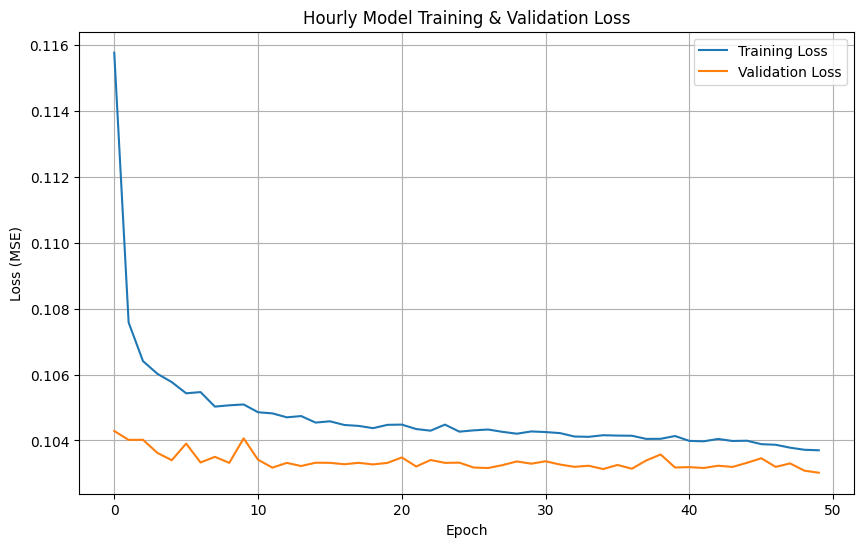


--- Evaluating Hourly Model ---
55/55 [==============================] - 0s 3ms/step
Validation Mean Absolute Error (MAE): 2.6248
Validation Mean Squared Error (MSE): 16.8090
Validation Root Mean Squared Error (RMSE): 4.0999
1/1 [==============================] - 0s 16ms/step


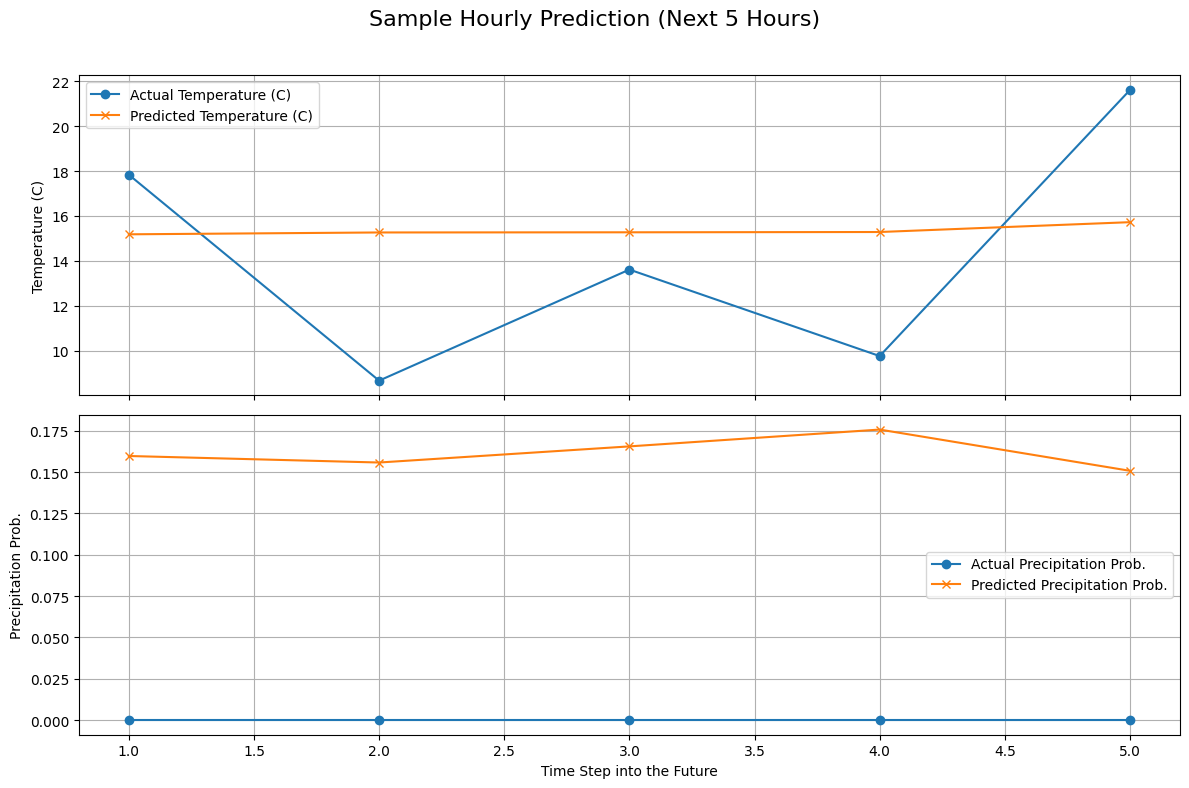


--- Building and Training Daily Prediction Model ---
Daily Training Data Shape: X=(264, 30, 9), y=(264, 9)
Daily Validation Data Shape: X=(67, 30, 9), y=(67, 9)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128)               70656     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 71,817
Trainable params: 71,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 2s 57ms/step - loss: 0.1423 - val_loss: 0.0450
Epoch 2/50
9/9 [==============================] - 0s 16

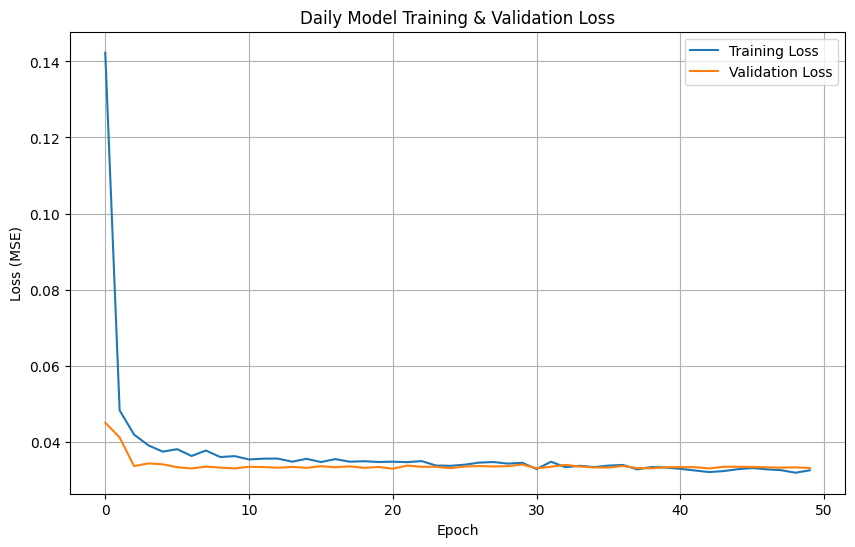


--- Evaluating Daily Model ---
3/3 [==============================] - 0s 3ms/step
Validation Mean Absolute Error (MAE): 0.4132
Validation Mean Squared Error (MSE): 0.4083
Validation Root Mean Squared Error (RMSE): 0.6390
1/1 [==============================] - 0s 17ms/step


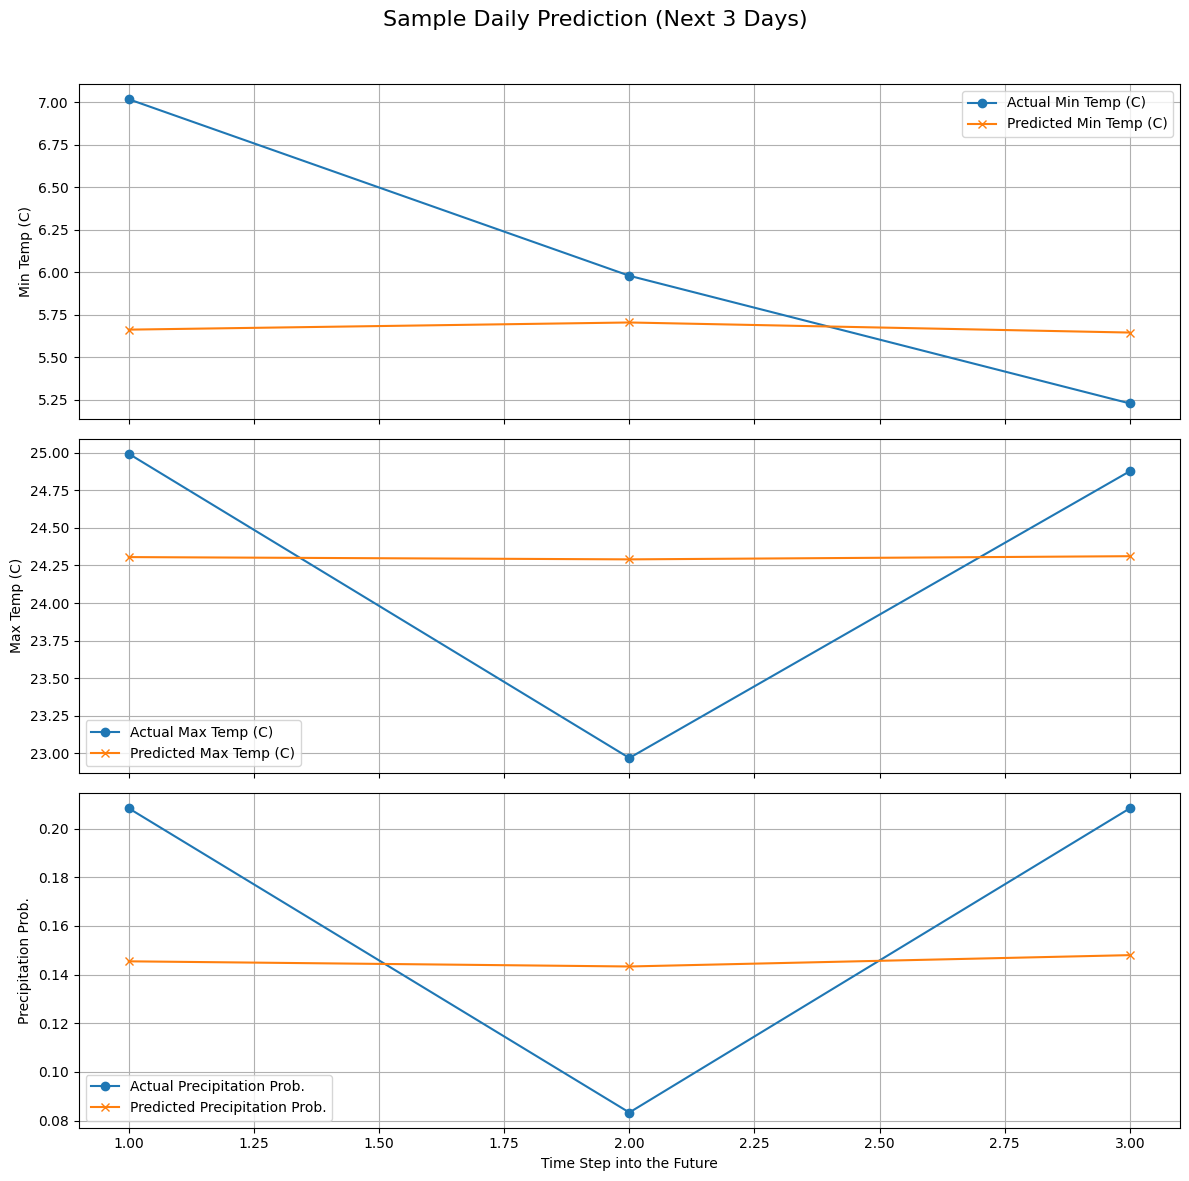

: 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- Configuration ---
# You can adjust these parameters
HOURLY_PAST_HISTORY = 24  # Use the last 24 hours to predict the future
HOURLY_FUTURE_TARGET = 5   # Predict the next 5 hours

DAILY_PAST_HISTORY = 30    # Use the last 30 days to predict the future
DAILY_FUTURE_TARGET = 3    # Predict the next 3 days

# --- 1. Data Loading and Preprocessing ---

def load_and_clean_data(filepath):
    """
    Loads the weather data from a CSV file, cleans it, and performs initial feature engineering.
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please make sure you have a CSV file with your weather data in the same directory.")
        # Create a dummy dataframe for demonstration purposes if file not found
        print("Creating a dummy dataframe to demonstrate the script's functionality.")
        data = {
            'DateTime': pd.to_datetime(pd.date_range(start='2020-01-01', periods=8728, freq='H')),
            'weather main': ['Clear'] * 8728,
            'weather description': ['clear sky'] * 8728,
            'Temperature (C)': np.random.uniform(5, 25, 8728),
            'feels like': np.random.uniform(4, 24, 8728),
            'Pressure (hPa)': np.random.randint(1000, 1020, 8728),
            'sea level pressure': [np.nan] * 8728,
            'grnd level pressure': [np.nan] * 8728,
            'Humidity %': np.random.randint(30, 90, 8728),
            'wind speed (m/s)': np.random.uniform(1, 10, 8728),
            'wind deg': np.random.randint(0, 360, 8728),
            'wind gust': np.random.uniform(2, 15, 8728),
            'cloudiness (%)': np.random.randint(0, 100, 8728),
            'rain volumn (mm/h)': [np.random.choice([0, 0.1, 0.5, 1.2], p=[0.85, 0.1, 0.04, 0.01]) for _ in range(8728)],
            'snow volumn (mm/h)': [np.nan] * 8728,
            'icon id': ['01d'] * 8728
        }
        df = pd.DataFrame(data)


    # Clean column names
    df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()

    # Convert DateTime to datetime object
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index('datetime')

    # Drop columns that are completely empty or not useful for the model
    df = df.drop(columns=['sea_level_pressure', 'grnd_level_pressure', 'snow_volumn_mm/h',
                          'weather_main', 'weather_description', 'icon_id'])

    # Handle missing values in rain volume (assume NaN means no rain)
    df['rain_volumn_mm/h'] = df['rain_volumn_mm/h'].fillna(0)

    # Feature Engineering: Create a binary precipitation column
    # This will be our target for "Probability of Precipitation"
    df['precipitation'] = (df['rain_volumn_mm/h'] > 0).astype(int)
    df = df.drop(columns=['rain_volumn_mm/h']) # Drop original rain column

    return df

# --- 2. Sequence Creation for LSTM ---

def create_sequences(data, past_history, future_target, target_cols_indices):
    """
    Creates input sequences (X) and corresponding future targets (y) for the LSTM model.
    """
    X, y = [], []
    start_index = past_history
    end_index = len(data) - future_target

    for i in range(start_index, end_index):
        indices = range(i - past_history, i)
        X.append(data[indices])

        # Correctly slice the data for the target 'y'
        # Select rows from i to i+future_target, and only the columns specified by target_cols_indices
        y.append(data[i:i + future_target, target_cols_indices])

    return np.array(X), np.array(y)


# --- 3. Visualization and Evaluation ---

def plot_training_history(history, title):
    """
    Plots the training and validation loss for a Keras model.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, X_val, y_val, scaler, num_targets, target_indices, all_cols, future_target, model_type='Hourly'):
    """
    Evaluates the model on validation data and prints metrics.
    """
    print(f"\n--- Evaluating {model_type} Model ---")
    # Predict on validation data
    y_pred_scaled = model.predict(X_val)

    # Inverse transform predictions and actuals
    # Reshape y_val from (samples, steps*features) to (samples, steps, features) for inverse transform
    y_val_reshaped = y_val.reshape(y_val.shape[0], future_target, num_targets)

    # We need to create dummy arrays to inverse transform only our target variables
    y_pred_inv = np.zeros((y_pred_scaled.shape[0], future_target, len(all_cols)))
    y_val_inv = np.zeros((y_val.shape[0], future_target, len(all_cols)))

    # Reshape prediction for easier indexing
    y_pred_scaled_reshaped = y_pred_scaled.reshape(y_pred_scaled.shape[0], future_target, num_targets)

    # Place scaled data into the dummy arrays
    y_pred_inv[:, :, target_indices] = y_pred_scaled_reshaped
    y_val_inv[:, :, target_indices] = y_val_reshaped

    # Inverse transform requires reshaping to 2D
    y_pred_inv = scaler.inverse_transform(y_pred_inv.reshape(-1, len(all_cols)))
    y_val_inv = scaler.inverse_transform(y_val_inv.reshape(-1, len(all_cols)))

    # Extract only the target columns
    y_pred = y_pred_inv[:, target_indices]
    y_true = y_val_inv[:, target_indices]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"Validation Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Validation Mean Squared Error (MSE): {mse:.4f}")
    print(f"Validation Root Mean Squared Error (RMSE): {rmse:.4f}")


# --- 4. Model 1: Hourly Predictions (Next 5 Hours) ---

def build_train_hourly_model(df):
    """
    Builds and trains the LSTM model for hourly predictions.
    """
    print("\n--- Building and Training Hourly Prediction Model ---")
    # Define features and targets
    features = ['temperature_c', 'feels_like', 'pressure_hpa', 'humidity_%',
                'wind_speed_m/s', 'wind_deg', 'wind_gust', 'cloudiness_%', 'precipitation']
    target_cols = ['temperature_c', 'precipitation']

    df_hourly = df[features].copy()

    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_hourly)

    # Find the indices of target columns in the scaled data
    target_indices = [df_hourly.columns.get_loc(col) for col in target_cols]

    # Create sequences
    X, y = create_sequences(scaled_data, HOURLY_PAST_HISTORY, HOURLY_FUTURE_TARGET, target_indices)

    # Reshape y to be (n_samples, n_timesteps * n_features) for the Dense layer
    y = y.reshape(y.shape[0], y.shape[1] * y.shape[2])

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Hourly Training Data Shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Hourly Validation Data Shape: X={X_val.shape}, y={y_val.shape}")

    # Build the LSTM model
    model = Sequential([
        LSTM(128, input_shape=X_train.shape[-2:]),
        Dropout(0.2),
        Dense(HOURLY_FUTURE_TARGET * len(target_cols)) # Output layer
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                        validation_data=(X_val, y_val), verbose=1)

    # Visualize and Evaluate
    plot_training_history(history, 'Hourly Model Training & Validation Loss')
    evaluate_model(model, X_val, y_val, scaler, len(target_cols), target_indices, df_hourly.columns, HOURLY_FUTURE_TARGET, 'Hourly')

    return model, scaler, df_hourly.columns, X_val, y_val

# --- 5. Model 2: Daily Predictions (Next 3 Days) ---

def build_train_daily_model(df):
    """
    Resamples data to daily, then builds and trains the LSTM model for daily predictions.
    """
    print("\n--- Building and Training Daily Prediction Model ---")
    # Resample data to daily frequency
    df_daily = df.resample('D').agg({
        'temperature_c': ['min', 'max'],
        'feels_like': 'mean',
        'pressure_hpa': 'mean',
        'humidity_%': 'mean',
        'wind_speed_m/s': 'mean',
        'wind_gust': 'mean',
        'cloudiness_%': 'mean',
        'precipitation': lambda x: (x > 0).mean() # Daily probability of precipitation
    })
    df_daily.columns = ['_'.join(col).strip() for col in df_daily.columns.values]
    df_daily = df_daily.dropna() # Drop days with no data

    # Define features and targets
    features = df_daily.columns
    target_cols = ['temperature_c_min', 'temperature_c_max', 'precipitation_<lambda>']

    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_daily)

    # Find the indices of target columns
    target_indices = [df_daily.columns.get_loc(col) for col in target_cols]

    # Create sequences
    X, y = create_sequences(scaled_data, DAILY_PAST_HISTORY, DAILY_FUTURE_TARGET, target_indices)
    y = y.reshape(y.shape[0], y.shape[1] * y.shape[2])

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Daily Training Data Shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Daily Validation Data Shape: X={X_val.shape}, y={y_val.shape}")

    # Build the LSTM model
    model = Sequential([
        LSTM(128, input_shape=X_train.shape[-2:]),
        Dropout(0.2),
        Dense(DAILY_FUTURE_TARGET * len(target_cols))
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, # More epochs for smaller dataset
                        validation_data=(X_val, y_val), verbose=1)

    # Visualize and Evaluate
    plot_training_history(history, 'Daily Model Training & Validation Loss')
    evaluate_model(model, X_val, y_val, scaler, len(target_cols), target_indices, df_daily.columns, DAILY_FUTURE_TARGET, 'Daily')

    return model, scaler, df_daily.columns, X_val, y_val


# --- 6. Prediction Visualization ---

def plot_prediction_vs_actual(model, X_sample, y_sample, scaler, all_cols, target_indices, future_target, title, y_labels):
    """
    Plots a single prediction sample against its actual value.
    """
    # Predict
    y_pred_scaled = model.predict(np.expand_dims(X_sample, axis=0))
    y_pred_reshaped = y_pred_scaled.reshape(future_target, len(target_indices))

    # Reshape actual y for inverse transform
    y_true_reshaped = y_sample.reshape(future_target, len(target_indices))

    # Inverse transform
    dummy_pred = np.zeros((future_target, len(all_cols)))
    dummy_true = np.zeros((future_target, len(all_cols)))
    dummy_pred[:, target_indices] = y_pred_reshaped
    dummy_true[:, target_indices] = y_true_reshaped

    y_pred_inv = scaler.inverse_transform(dummy_pred)[:, target_indices]
    y_true_inv = scaler.inverse_transform(dummy_true)[:, target_indices]

    # Plot
    num_targets = len(target_indices)
    fig, axes = plt.subplots(num_targets, 1, figsize=(12, 4 * num_targets), sharex=True)
    if num_targets == 1:
        axes = [axes] # Make it iterable
    fig.suptitle(title, fontsize=16)

    time_steps = np.arange(1, future_target + 1)

    for i, ax in enumerate(axes):
        ax.plot(time_steps, y_true_inv[:, i], 'o-', label=f'Actual {y_labels[i]}')
        ax.plot(time_steps, y_pred_inv[:, i], 'x-', label=f'Predicted {y_labels[i]}')
        ax.set_ylabel(y_labels[i])
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel('Time Step into the Future')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- 7. Main Execution ---
if __name__ == '__main__':
    # Make sure to replace 'your_weather_data.csv' with the actual name of your file
    filepath = 'your_weather_data.csv'
    master_df = load_and_clean_data(filepath)

    if master_df is not None:
        # --- Run Hourly Model ---
        hourly_model, hourly_scaler, hourly_cols, X_val_h, y_val_h = build_train_hourly_model(master_df)

        # Visualize an example prediction (Hourly)
        hourly_target_indices = [hourly_cols.get_loc('temperature_c'), hourly_cols.get_loc('precipitation')]
        plot_prediction_vs_actual(
            model=hourly_model,
            X_sample=X_val_h[50], # Taking 50th sample from validation set
            y_sample=y_val_h[50],
            scaler=hourly_scaler,
            all_cols=hourly_cols,
            target_indices=hourly_target_indices,
            future_target=HOURLY_FUTURE_TARGET,
            title=f"Sample Hourly Prediction (Next {HOURLY_FUTURE_TARGET} Hours)",
            y_labels=['Temperature (C)', 'Precipitation Prob.']
        )

        # --- Run Daily Model ---
        daily_model, daily_scaler, daily_cols, X_val_d, y_val_d = build_train_daily_model(master_df)

        # Visualize an example prediction (Daily)
        daily_target_indices = [daily_cols.get_loc('temperature_c_min'), daily_cols.get_loc('temperature_c_max'), daily_cols.get_loc('precipitation_<lambda>')]
        plot_prediction_vs_actual(
            model=daily_model,
            X_sample=X_val_d[10], # Taking 10th sample from validation set
            y_sample=y_val_d[10],
            scaler=daily_scaler,
            all_cols=daily_cols,
            target_indices=daily_target_indices,
            future_target=DAILY_FUTURE_TARGET,
            title=f"Sample Daily Prediction (Next {DAILY_FUTURE_TARGET} Days)",
            y_labels=['Min Temp (C)', 'Max Temp (C)', 'Precipitation Prob.']
        )
